# Introduction:

In this project I have demonstrated how to create and train a sequence-to-sequence Transformer model to translate French into English.
The Transformer was originally proposed in "Attention is all you need" by Vaswani et al. (2017).

* Transformers are deep neural networks that replace CNNs and RNNs with self-attention. Self attention allows Transformers to easily transmit information across the input sequences.

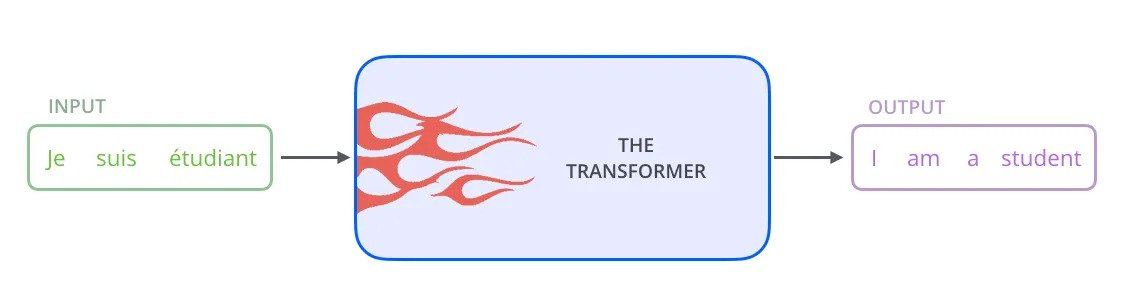

**An explanation:**

1. Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it.
2. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder.
3. The Transformer starts by generating initial representations, or embeddings, for each word...
4. Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls.
5. This step is then repeated multiple times in parallel for all words, successively generating new representations.

# Transformer vs  seq2seq + Attention mechanism:

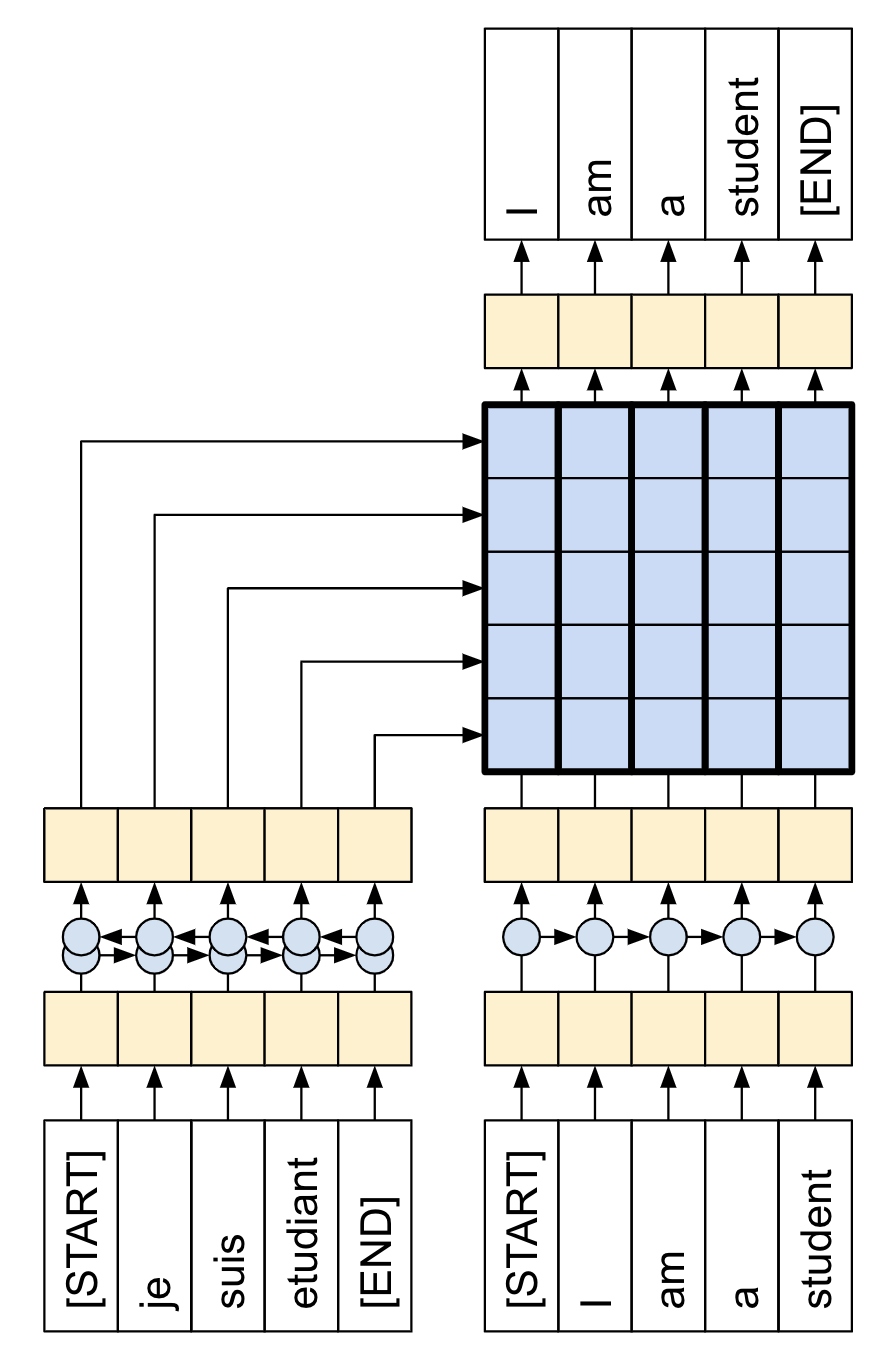

# The Project pipeline:
* Prepare the data.
* Implement necessary components:
1. Positional embeddings.
2. Attention layers.
3. The encoder and decoder.
* Build & train the Transformer.
* Generate translations.
* Visualized attention weights

# Setup
Begin by installing TensorFlow Datasets for loading the dataset and TensorFlow Text for text preprocessing:

In [ ]:
# Import the necessary modules:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,LayerNormalization,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,MultiHeadAttention,Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
# For GPU

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# Data handling

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip
!unzip "/content/fra-eng.zip" -d "/content/dataset/"


--2023-08-01 17:27:49--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip.4’

fra-eng.zip.4       100%[===================>]   7.40M  21.3MB/s    in 0.3s    

2023-08-01 17:27:50 (21.3 MB/s) - ‘fra-eng.zip.4’ saved [7757635/7757635]



# Data Processing

In [ ]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
# embedding config

VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=256
BATCH_SIZE=64

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)# input x,y and output x
english_vectorize_layer.adapt(english_training_data)# adapt the vectorize_layer to the training data

In [ ]:

french_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
# Set num of batches
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
# Data spilt into train and validate

train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# Modeling

# Positional Embedding

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
print(positional_encoding(256,64).shape)

(1, 64, 256)


In [ ]:
# Build Embeddings layer and compute mask.

class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)


In [ ]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


In [ ]:
mask=emb.compute_mask(test_input)
mask1 = mask[:, :, tf.newaxis]
mask2 = mask[:,tf.newaxis, :]
padding_mask = tf.cast(mask1&mask2, dtype="int32")
print(1-padding_mask)

tf.Tensor(
[[[0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1 1]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]
  [1 1 1 1 1 1 1 1]]], shape=(1, 8, 8), dtype=int32)


# MultiHeadAttention

# Encoder

In [ ]:
# Build Multi head Transformer Encoder layer.
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        # As per paper has suggested, we will be using 2 LayerNormalization in encoder block.
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]

        # Construct padding mask,which is combination of mask1,mask2 using &(and) operator. Output of this operation would be boolen so cast it into int32.
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask)

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

In [ ]:
# initialize TransformerEncoder class, here we need to pass embedding output.

encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)


(1, 8, 256)


# Decoder

In [ ]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads,):
    super(TransformerDecoder, self).__init__()
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads

    # 2 attention layers will be build (attention_1 & attention_2)
    self.attention_1=MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

    self.attention_2=MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dim, activation="relu"),Dense(embed_dim),])

    # As paper has suggested to use 3 LayerNormalization, so in the decoder block we will be using 3 Layer Normalization.
    self.layernorm_1=LayerNormalization()
    self.layernorm_2=LayerNormalization()
    self.layernorm_3=LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, mask=None):
    if mask is not None:
      mask1 = mask[:, :, tf.newaxis]
      mask2 = mask[:,tf.newaxis, :]
      padding_mask = tf.cast(mask1&mask2, dtype="int32") # same intuition, as we did it in encoder block.

      # What is causal masking in transformers?
      # Causal masking is used to prevent the model from attending to future tokens during training, so that it can only rely on information from past tokens to predict the next token.

      # Now to do this, there are two approches 1) build custom masking approch aka causal_mask, 2) approch would be to use tensorflow use_causal_mask=True.

      # Here, we will build own custom causal masking.
      # we've used tensorflow Module: tf.linalg, which is operations for linear algebra.
      # tf.linalg has function called band_part(), which "Copy a tensor setting everything outside a central band in each innermost matrix to zero".
      # So, the idea is, create Lower triangular part using -1,0 as num_lower & num_upper.
      # here, we want causal_mask shape = batch(B) by sequence length(S) by sequence length(S), so ([0],[1],[1])
      causal_mask=tf.linalg.band_part(tf.ones([tf.shape(inputs)[0],
                                               tf.shape(inputs)[1],
                                               tf.shape(inputs)[1]],dtype=tf.int32),-1,0)

      combined_mask=tf.minimum(padding_mask,causal_mask) # we want to choose minimum value, such as if (1,0)--> 0 / if (1,1)-->1

    # As per the paper, multi head attention layer one is masked,
    # we've to implement the causal masking, such that any given token doesn't attend to future tokens.
    # So we've a combination of padding and causal mask to optain the output mask.
    attention_output_1 = self.attention_1(
        query=inputs,key=inputs,value=inputs,
        attention_mask=causal_mask,)

    # Next input + output from first multihead attention layer pass through layer normalization 1.
    out_1 = self.layernorm_1(inputs + attention_output_1)
    # This out_1 is the query (Q) of multi head attention 1 and key(k), value(v) will come encoder output block.

    # This multi head attention layer is unmasked. So it's just the attention with the padding mask.
    attention_output_2,scores= self.attention_2(
        query=out_1,key=encoder_outputs,value=encoder_outputs,
        attention_mask=combined_mask,
        return_attention_scores=True)

    # Next input(which is output from first multihead attention layer) + output from second multihead attention layer pass through layer normalization 2.
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    # Next we pass output_2 through feed forward network (Dense layer with Relu activation function)
    proj_output = self.dense_proj(out_2)

    # Fianlly, we pass out_2 (which is layernorm_2 output) + proj_output through last layer normalization 3.
    return self.layernorm_3(out_2 + proj_output),scores
    # now we are done with decoder.

In [ ]:
# initialize TransformerDecoder class, here we need to pass embedding output and Transformer encoder block output.
decoder_outputs,scores = TransformerDecoder(256,2048,4)(emb_out,encoder_outputs)
print(decoder_outputs.shape)
print(scores.shape)

(1, 8, 256)
(1, 4, 8, 8)


# Transformer Model

In [ ]:
# Model configuration

EMBEDDING_DIM=256     # embedding dimension in custom-->128
D_FF=2048             # Desne layer in custom--> 1024
NUM_HEADS=8           # Number of multihead
NUM_LAYERS=4          # Number of layers, where N is number of encode layer & number of decoder layer
NUM_EPOCHS=10         # Number of epoch iterations
attention_scores={}   # we will use this dict for visualization attention score.

In [ ]:
#1) initialize encoder input as input_1
encoder_inputs=Input(shape=(None,), dtype="int64", name="input_1")

# Construct positional encoding for multihead encoder block
x = Embeddings(ENGLISH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_inputs)

# pass x(Embeddings output-->ENGLISH_SEQUENCE) through Number of layers & get encoder output.
for _ in range(NUM_LAYERS):
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)
encoder_outputs=x

#2) initialize decoder input as input_2
decoder_inputs=Input(shape=(None,), dtype="int64", name="input_2")

# Construct positional encoding for multihead decoder block
x = Embeddings(FRENCH_SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(decoder_inputs)

# pass x(Embeddings output-->FRENCH_SEQUENCE) through Number of layers & get decoder output.
for i in range(NUM_LAYERS):
  x,scores=TransformerDecoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x, encoder_outputs)
  attention_scores[f'decoder_layer{i+1}_block2']=scores

# Now here, we want to go from output of shape B(batch),S(sequence length),D_model-->to an output of shape B,S,V(vocabulary size).
# So that every time-step, we'll be able to get the specific word.
# As per paper, we are going to have linear layer, for above task.
decoder_outputs=Dense(VOCAB_SIZE, activation="softmax")(x)

# To calculate attention score of model.
attention_score_model= tf.keras.Model(
    [encoder_inputs, decoder_inputs], attention_scores, name="atttention_score_model"
)

# Finally, we initialize transformer model, here input is multihead encoder input & multihead decoder input.
transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings_1 (Embeddings)      (None, 64, 256)      5120000     ['input_1[0][0]']                
                                                                                                  
 transformer_encoder_1 (Transfo  (None, 64, 256)     3155456     ['embeddings_1[0][0]']           
 rmerEncoder)                                                                                     
                                                                                                  
 transformer_encoder_2 (Transfo  (None, 64, 256)     3155456     ['transformer_encoder_1

# Training

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
with tf.device(device_name):
  transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(2e-4),)
                      #metrics=[BLEU()],
                      #run_eagerly=True)

In [ ]:
with tf.device(device_name):
  history=transformer.fit(train_dataset,validation_data=val_dataset.take(300),epochs=NUM_EPOCHS)

Epoch 1/10
2812/2812 [==============================] - 1312s 451ms/step - loss: 3.9446 - val_loss: 3.2553
Epoch 2/10
2812/2812 [==============================] - 1249s 444ms/step - loss: 2.2437 - val_loss: 2.3851
Epoch 3/10
2812/2812 [==============================] - 1232s 438ms/step - loss: 1.5753 - val_loss: 2.0371
Epoch 4/10
2812/2812 [==============================] - 1232s 438ms/step - loss: 1.2248 - val_loss: 1.8686
Epoch 5/10
2812/2812 [==============================] - 1231s 438ms/step - loss: 1.0098 - val_loss: 1.7812
Epoch 6/10
2812/2812 [==============================] - 1235s 439ms/step - loss: 0.8650 - val_loss: 1.7496
Epoch 7/10
2812/2812 [==============================] - 1232s 438ms/step - loss: 0.7605 - val_loss: 1.7155
Epoch 8/10
2812/2812 [==============================] - 1238s 440ms/step - loss: 0.6805 - val_loss: 1.7125
Epoch 9/10
2812/2812 [==============================] - 1233s 438ms/step - loss: 0.6179 - val_loss: 1.7286
Epoch 10/10
2812/2812 [==============

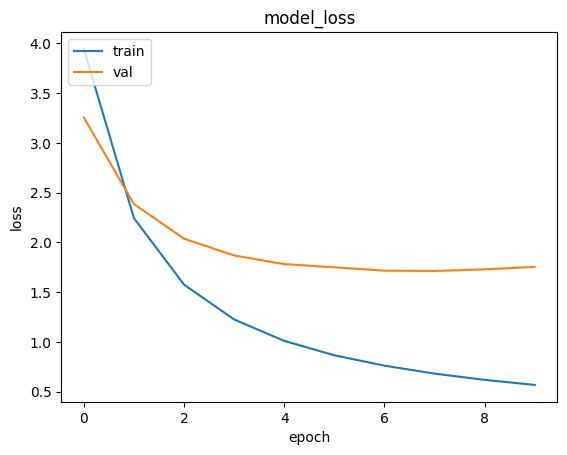

In [ ]:
# visualize model loss.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# evaluate model on validation data
with tf.device(device_name):
  transformer.evaluate(val_dataset)

748/748 [==============================] - 163s 169ms/step - loss: 2.6561


# Testing our transformer model to translate english sentences to french

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that it is not true?')

1/1 [==============================] - 0s 34ms/step


'questce qui vous fait penser que ce nest pas vrai'

In [ ]:
translator('Have you ever watched soccer under the rain?')

1/1 [==============================] - 0s 36ms/step


'avezvous déjà joué au foot sous la pluie'

In [ ]:
translator("what's your name?")

1/1 [==============================] - 0s 36ms/step


'quel est le nom de ton nom de quel [UNK]'

In [ ]:
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')

1/1 [==============================] - 0s 36ms/step


'de nos adultes ne poussent pas sur les poissons'

In [ ]:
translator('My hotel told me to call you. ')

1/1 [==============================] - 0s 44ms/step


'mon hôtel ma dit de vous appeler'

In [ ]:
translator('His French is improving little by little')

1/1 [==============================] - 0s 37ms/step


'son français saméliore un peu'

# Visualization

In [ ]:
def visualize(english_sentence):
  with tf.device('/device:GPU:0'):
    tokenized_english_sentence=english_vectorize_layer([english_sentence])

    # Input to the multihead transformer decoder layer.
    shifted_target='starttoken je lai fait très bien'

    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    attention_weights=attention_score_model.predict([tokenized_english_sentence,
                                                   tokenized_shifted_target])

    return attention_weights

out=visualize('I did it very well')


1/1 [==============================] - 5s 5s/step


In [ ]:
print(out['decoder_layer1_block2'][0].shape)

(8, 64, 64)


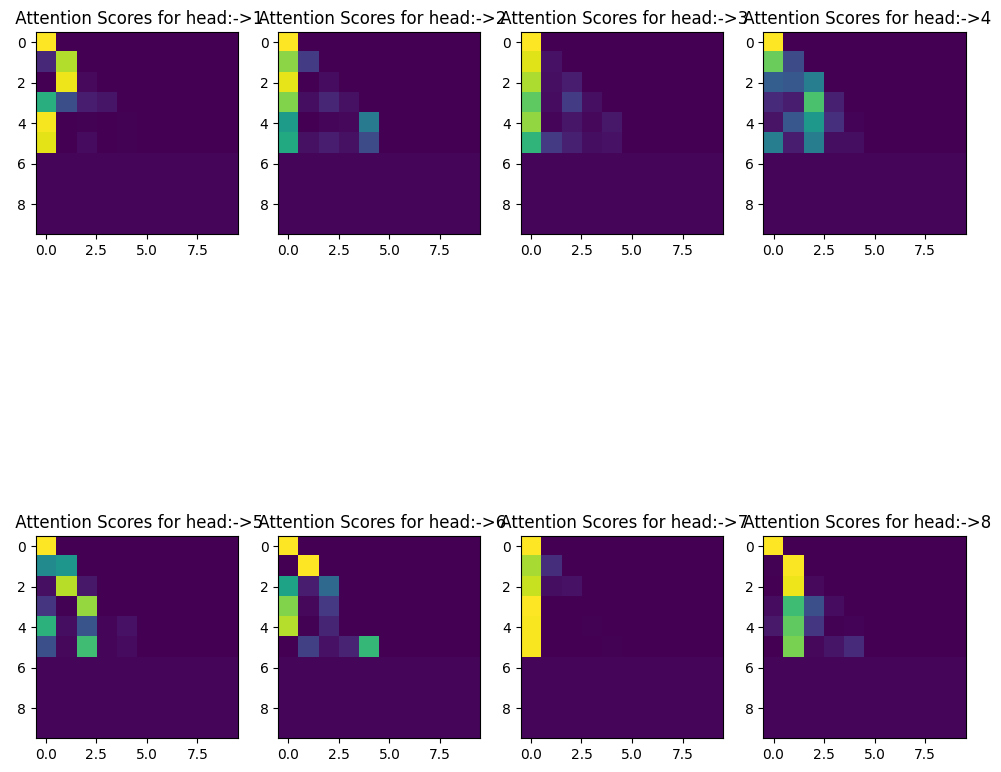

In [ ]:
plt.figure(figsize = (12,12))

for i in range(NUM_HEADS):
  ax = plt.subplot(2,4, i+1)

  plt.imshow(out['decoder_layer1_block2'][0][i][0:10,0:10])
  plt.title(" Attention Scores for head:->" +str(i+1))

The output showed attention score for each head, we go from head 1 right upto head 8. It shows the relationship between each and every English word and all the French words. We can see that some words will attend more to others as compared to the reamining other words.

Here, the model manifest it go from those default weight values to these attention weights.